<a href="https://colab.research.google.com/github/agaldran/uqinmia-miccai-2023/blob/main/part2_uncertainty/ensembles_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Quantification in Medical Image Analysis (UQinMIA @ MICCAI 2023)

## *Hands-on*: Part 2. 3D MRI Segmentation of White Matter Multiple Sclerosis Lesions: Voxel and Structural Uncertainty
### *Led by Nataliia Molchanova and Vatsal Raina*

## Setup

In [ ]:
# install MONAI Python library
!pip install monai==0.9.0
!pip install nilearn
# Download test set
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fvyBzSCg7JTIDf4E3R4pCU-1hwL9zSoK' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1fvyBzSCg7JTIDf4E3R4pCU-1hwL9zSoK" -O data.tar.gz && rm -rf /tmp/cookies.txt
!tar -xzvf data.tar.gz
# Download model weights
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1eTTgga7Cd1GjR0YupVbLuLd3unl6_Jj3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1eTTgga7Cd1GjR0YupVbLuLd3unl6_Jj3" -O models.tar.gz && rm -rf /tmp/cookies.txt
!tar -xzvf models.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 20.9 MB/s eta 0:00:00
--2023-09-29 09:01:59--  https://docs.google.com/uc?export=download&confirm=t&id=1fvyBzSCg7JTIDf4E3R4pCU-1hwL9zSoK
Resolving docs.google.com (docs.google.com)... 142.250.159.101, 142.250.159.138, 142.250.159.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.159.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u2imgc0avf01teahuf88t4r98cdjtqoo/1695978075000/17412464615910489214/*/1fvyBzSCg7JTIDf4E3R4pCU-1hwL9zSoK?e=download&uuid=ebdc3552-7cad-4f5d-9e1a-1d221a6fab16 [following]
--2023-09-29 09:02:00--  https://doc-0s-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u2imgc0avf01teahuf88t4r98cdjtqoo/1695978075000/17412464615910489214/*/1fvyBzSCg7JTIDf4E3R4pCU-1h

In [ ]:
# imports
import os
from glob import glob
import re
import numpy as np
from scipy import ndimage
# mri data handling and plotting
import nibabel as nib
from nilearn.plotting import plot_roi, plot_img, show
# monai
from monai.data import CacheDataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,Compose,CropForegroundd,LoadImaged,Orientationd,RandCropByPosNegLabeld,
    ScaleIntensityRanged,Spacingd,ToTensord,ConcatItemsd,NormalizeIntensityd, RandFlipd,
    RandRotate90d,RandShiftIntensityd,RandAffined,RandSpatialCropd, AsDiscrete
)
import torch
# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## I. Task description

**Introduction:**

White matter lesion (WML) segmentation in magnetic resonance imaging (MRI) scans is a crucial step for multiple sclerosis diagnosis and prognosis.


To perform white matter lesion segmentation, we aim to generate a binary segmentation mask $S$, with the same dimensions as the input image, where each voxel is assigned a value of either 0 or 1. A value of 0 indicates that the voxel does not belong to a white matter lesion, while a value of 1 indicates that the voxel is part of a white matter lesion.

Uncertainty quantification methods aim to capture uncertainty in a model's segmentation. Given the nature of the segmentation task, uncertainty quantification is possible at either:


1.   Voxel scale: An uncertainty score is calculated for every voxel in the segmentation mask.
2.   Structural scale: An uncertainty score is calculated for a specified region of the segmentation, for example, a predicted lesion.


**Classes:** 2 (0-background, 1-WML)

**Images shape:** ± 158x260x260

**Medical imaging modality:** MRI (3D FLAIR scans)

**References:**

[1] Malinin et al. "Shifts 2.0: Extending The Dataset of Real Distributional Shifts." Shifts Challenge 2022 (2022).

[2] Molchanova et al. "Novel Structural-Scale Uncertainty Measures and Error Retention Curves: Application to Multiple Sclerosis." ISBI23 Conference (2023).

**Example image:**

(A) Ground-truth lesions

(B) Predicted lesions

(C) Structural-scale uncertainty map

(D) Voxel-scale uncertainty map

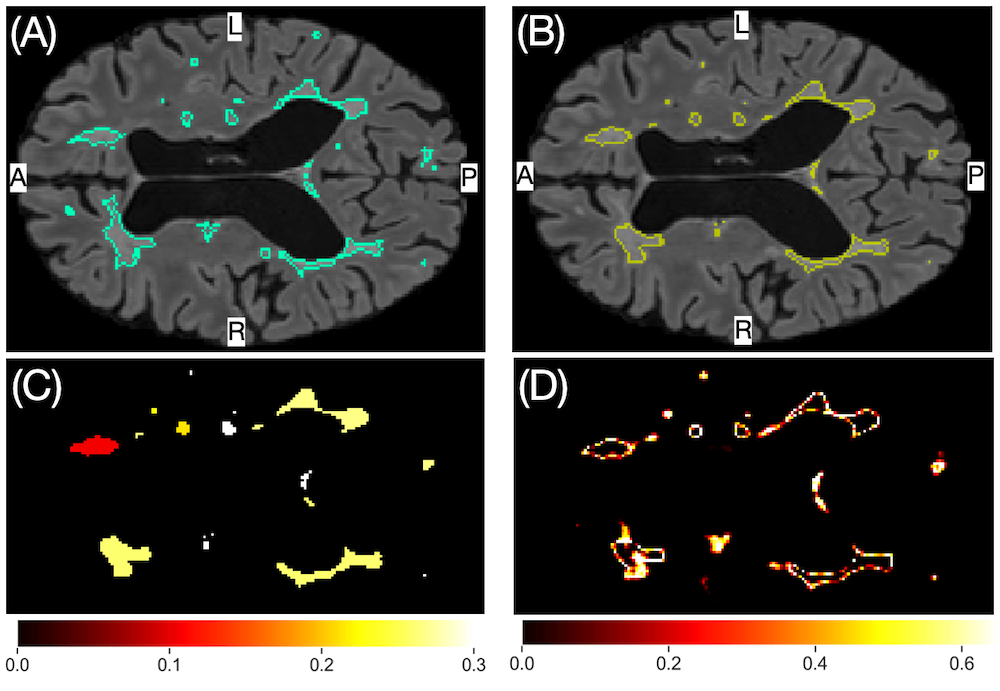

Loading the data for evaluation

In [ ]:
# define paths to the test images and ground truths
test_files = [
    {
        "image": os.path.join("dev_in", f"{i_s}_FLAIR.nii.gz"),
        "label": os.path.join("dev_in", f"{i_s}_gt.nii")
        }
    for i_s in range(1, 8)
]

# define the transforms pipeline: load image, add channel, interpolate to isovoxel space, normalise intensity, convert to torch tensor
transforms = Compose(
    [
      LoadImaged(keys=["image", "label"]),
      AddChanneld(keys=["image","label"]),
      Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
      NormalizeIntensityd(keys=["image"], nonzero=True),
      ToTensord(keys=["image", "label"])
      ]
    )

# define the dataloader
test_dataset = CacheDataset(
    data=test_files, transform=transforms, cache_rate=0.5, num_workers=0
    )

Loading dataset: 100%|██████████| 3/3 [00:21<00:00,  7.03s/it]


## II. Uncertainty Quantification with Deep Ensembles

1. Train an ensemble of $K$ similar models with different random initialization seeds.

 Random initialization seed can control data sampling, random transformations, stochastic optimization algorithms, and other processes during training. In the end, you will get $K$ models trained on the same data, but converging to different local minima.

2. Given a test example, perform an inference with each of the ensemble members.

 Generate a vector of $K$ samples by iteratively inferencing members' models and obtaining output softmax probabilities corresponding to different random seed initializations.
3. Compute uncertainty.

 By quantifying the disagreement/spread of the obtained sample, e.g. entropy.

 Other measures can also be considered and the information brought by different measures will vary.

### Model training

  The training code for the current task can be found in the [Shifts Challenge GitHub](https://github.com/Shifts-Project/shifts/tree/main/mswml). We will use the pre-trained weights.

In [ ]:
# define the ensemble of 3D UNet models and load model weights
models = [
    UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        num_res_units=0
        ).to(device)
    for _ in range(3)
]

for k, model in enumerate(models):
  model.load_state_dict(
                  torch.load(
                      os.path.join("baselines", f'seed{k+1}', 'Best_model_finetuning.pth'),
                      map_location=device
                      )
                  )
  model.eval()

# define the activation function
activation = torch.nn.Softmax(dim=1)

# define the threshold to convert softmax prediction into binary segmentation mask
proba_threshold = 0.35

### Inference

In [ ]:
# additional functions
def remove_small_connected_components(segmentation, l_min=9):
    """Remove small lesions leq than `l_min` voxels from the binary segmentation mask.
    """
    if l_min > 0:
        if segmentation.ndim != 3:
            raise ValueError(f"Mask must have 3 dimensions, got {segmentation.ndim}.")
        struct_el = ndimage.generate_binary_structure(rank=3, connectivity=2)
        labeled_seg, num_labels = ndimage.label(segmentation, structure=struct_el)
        segmentation_tr = np.zeros_like(segmentation)
        for label in range(1, num_labels + 1):
            if np.sum(labeled_seg == label) > l_min:
                segmentation_tr[labeled_seg == label] = 1
        return segmentation_tr
    else:
        return segmentation.copy()

# pick an example subject
batch_data = test_dataset[0]
inputs = batch_data["image"].unsqueeze(0).to(device)
labels = batch_data["label"].type(torch.LongTensor).to(device)

# perform inference for each of the ensemble members

with torch.inference_mode():
  mems_pred = []
  for model in models:
    # infer sub-volumes of 96x96x96 size that aggregated using gaussian smoothing
    mem_pred = sliding_window_inference(inputs, (96, 96, 96), 4, model, mode='gaussian')
    # apply softmax
    mem_pred = activation(mem_pred)
    # conver to numpy, leave only softmax probabilities related to the lesion class
    mem_pred = np.squeeze(mem_pred[0,1].cpu().numpy())
    # add to the ensemble predictions
    mems_pred.append(mem_pred)

mems_pred = np.asarray(mems_pred)

# ensemble prediction is an average across members softmax probas
ens_pred = np.mean(mems_pred, axis=0)

# get binary lesion mask by applying a probability threshold to the softmax predictions
ens_seg = np.where(ens_pred > proba_threshold, 1., 0.)

# remove predicted lesions that are too small
ens_seg = remove_small_connected_components(ens_seg)

# generate lesion masks for each of members
mems_seg = [np.where(mem_pred > proba_threshold, 1., 0.) for mem_pred in mems_pred]
mems_seg = [remove_small_connected_components(mem_seg) for mem_seg in mems_seg]
mems_seg = np.asarray(mems_seg)

### Uncertainty measures computation

In this tutorial, we consider two distinct types of measures: voxel-wise and structure-wise. Voxel-wise uncertainty should be related to the misclassification errors. However, structure-wise, or in our case lesion-wise uncertainty is informative of lesion-scale errors, e.g. lesion false detection.

#### **A. Voxel-scale uncertainty**

If we treat segmentation as a classification in each voxel, we can compute uncertainty using the same principles as for the classification task.

Here, we consider several measures of uncertainty that correspond to different sources of uncertainty: total, data, and knowledge.

**Total uncertainty measures:**
- Negated confidence
- Entropy of expected

**Data uncertainty:**
- Expected entropy

**Knowledge uncertainty:**
- Mutual information (MI) = total - data uncertainty
- Expected pair-wise KL divergence (EPKL) = upper bound of knowledge uncertainty
- Reverse mutual information = EPKL - MI

For this tutorial, *entropy of expected* is used. For the rest of the measures, the code is provided.

$$  
\text{entropy of expected } = -\sum_y \frac{1}{K}\sum_{k=1}^K P_{k}(\mathbf{y}) \log\left[\frac{1}{K}\sum_{k=1}^K P_{k}(\mathbf{y})\right]
$$
where $P_k(y)$ denotes the probability distribution over the binary classes from the $k^{\text{th}}$ member of the ensemble.

In [ ]:
# Implementation of standard predictive uncertainty measures for image classification / segmentation
# Source: Shifts Challenge GitHub https://github.com/Shifts-Project/shifts/tree/main

def entropy_of_expected(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=-1)

def expected_entropy(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    log_probs = -np.log(probs + epsilon)
    return np.mean(np.sum(probs * log_probs, axis=-1), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    All measures combined.
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: Dictionary of uncertainties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=-1)

    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)

    mutual_info = eoe - exe

    epkl = -np.sum(mean_probs * mean_lprobs, axis=-1) - exe

    uncertainty = {'confidence': -1 * conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'reverse_mutual_information': epkl - mutual_info
                   }

    return uncertainty

In [ ]:
# for an example subject compute voxel-scale uncertainty
vox_uncs_map = ensemble_uncertainties_classification(
    np.concatenate([
        np.expand_dims(mems_pred, axis=-1),
        np.expand_dims(1. - mems_pred, axis=-1)
        ], axis=-1)
    )["entropy_of_expected"]

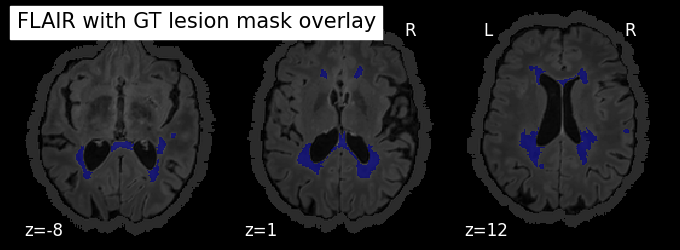

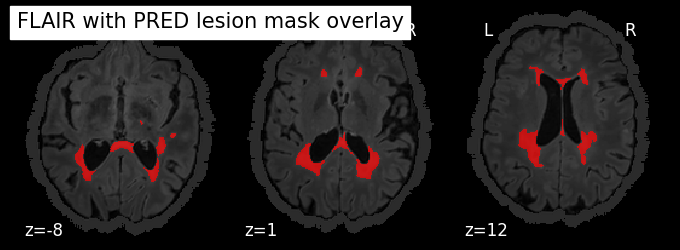

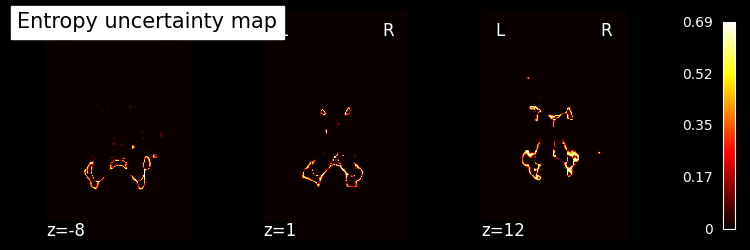

In [ ]:
# visualise the predictions and the uncertainty maps
affine = batch_data['image_meta_dict']['affine']
flair_scan = nib.Nifti1Image(batch_data['image'][0].numpy(), affine=affine)
gt_mask = nib.Nifti1Image(batch_data['label'][0].numpy(), affine=affine)
pred_mask = nib.Nifti1Image(ens_seg, affine=affine)
vox_uncs_heatmap = nib.Nifti1Image(vox_uncs_map, affine=affine)

plot_roi(gt_mask, flair_scan, display_mode='z', title='FLAIR with GT lesion mask overlay', cut_coords=(-8, 1, 12))
plot_roi(pred_mask, flair_scan, display_mode='z', title='FLAIR with PRED lesion mask overlay', cut_coords=(-8, 1, 12), cmap='autumn')
plot_img(vox_uncs_heatmap, display_mode='z', title='Entropy uncertainty map', cut_coords=(-8, 1, 12), cmap='hot', colorbar=True, black_bg=True)
show()

#### **B. Lesion-scale uncertainty**

In a segmentation task, the prediction is not a single number, but a sequence of pixels/voxels. With this, uncertainty can be quantified not just for each pixel/voxel, but also for a set of pixels/voxels.

For the task of WML segmentation, for instance, we can compute uncertainty for each voxel prediction, but we can also compute it for each predicted lesion area.

The most common way to compute this uncertainty is to aggregate the voxel uncertainties from the lesion region, e.g. average across the lesion region voxel-scale uncertainty:
$$\mathbb{E}_{\Omega}(U)=\frac{1}{|\Omega|}\sum_{{i} \in \Omega} U({i}),$$ where ${i}$ is a voxel index and the lesion region $\Omega$ is determined from a binary segmentation mask predicted by an ensemble model as a connected component.

Another approach is to look at the disagreement between the structural predictions directly. For the measure proposed in [Novel structural-scale uncertainty measures and error retention curves: application to multiple sclerosis](https://https://arxiv.org/abs/2211.04825v2), called detection disagreement uncertainty (DDU):

$$DDU=1 - \frac{1}{K} \sum_{k=1}^K IoU(\Omega, \Omega_k)$$

$\Omega_k, k=1,2,...,K$ - lesion regions in the binary segmentation maps of the ensemble members. $\Omega_k$ is defined as a connected component on the binary lesion mask predicted by the $k^{th}$ member that has an intersection with $\Omega$. In case there are several connected components intersecting with the $\Omega$, only the one with the greatest intersection over union is used.

In [ ]:
def intersection_over_union(mask1, mask2):
    """Compute IoU for 2 binary masks
    mask1 and mask2 should have same dimensions
    """
    return np.sum(mask1 * mask2) / np.sum(mask1 + mask2 - mask1 * mask2)


def ddu_measure(pred_lesion_mask: np.ndarray, inst_mems_seg_masks: np.ndarray) -> float:
    """ Compute detection disagreement uncertainty measure for a single lesion.

    :param pred_lesion_mask: binary mask of a lesion, shape [H, W, D]
    :param inst_mems_seg_masks: instance lesion masks predicted by ensemble members, shape [M, H, W, D].
    :return: dictionary of lesion uncertainty measures names and values
    :rtype: float

    Original paper: https://arxiv.org/abs/2211.04825
    Original implementation: https://github.com/NataliiaMolch/MS_WML_uncs
    """
    # iou between the lesion regions predicted by ensemble and members
    ens_ious = []

    # number of ensemble members
    M = inst_mems_seg_masks.shape[0]

    for m in range(M):
      # maximum across all the lesions predicted by the member iou with the pred_lesion_mask
      max_iou = 0.0

      # search across all the lesios predicted by the member that have non-zero intersection with the pred_lesion_mask
      for intersec_label in np.unique(pred_lesion_mask * inst_mems_seg_masks[m]):
          if intersec_label != 0.0:
              lesion_m = (inst_mems_seg_masks[m] == intersec_label).astype(float)
              iou = intersection_over_union(pred_lesion_mask, lesion_m)
              max_iou = iou if iou > max_iou else max_iou

      ens_ious.append(max_iou)

    return 1. - np.mean(ens_ious)

In [ ]:
# compute an instance predicted lesion mask, and the number of instances
structural_element = ndimage.generate_binary_structure(3,3)
instance_ens_seg, num_instances = ndimage.label(
    ens_seg, structure=structural_element
    )
# repeat the same for each ensemble member
instance_mems_seg = [
    ndimage.label(mem_seg, structure=structural_element)[0]
    for mem_seg in mems_seg
]
instance_mems_seg = np.asarray(instance_mems_seg)

# for each predicted lesion compute an uncertainty score and create a map
les_uncs_map = np.zeros_like(ens_seg)

# for each lesion compute an uncertainty score based on structural disagreement
for i_n in range(1, num_instances + 1):
  lesion_mask = (instance_ens_seg==i_n).astype(float)

  # compute a DDU
  les_unc = ddu_measure(lesion_mask, instance_mems_seg)

  # add an uncertainty to a map
  les_uncs_map += les_unc * lesion_mask

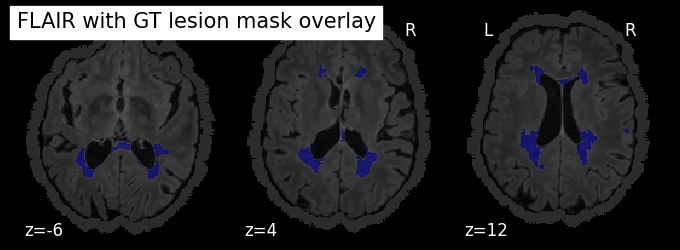

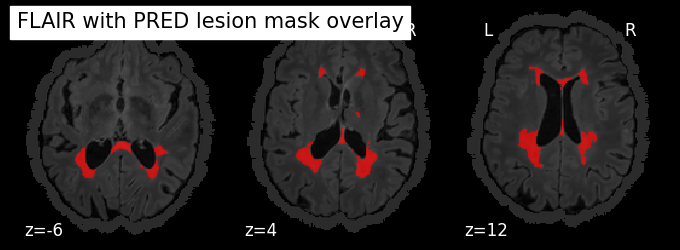

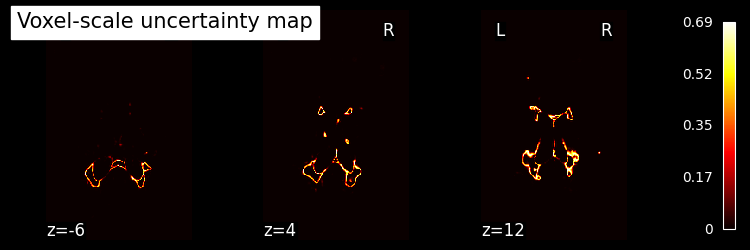

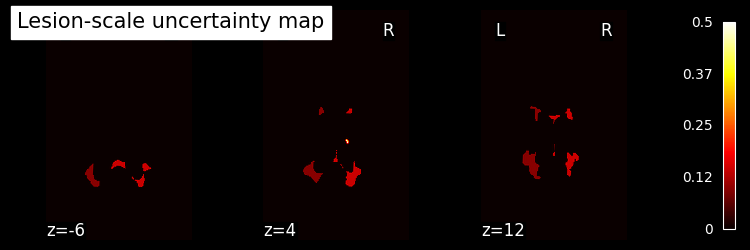

In [ ]:
# visualise the predictions and the uncertainty maps
affine = batch_data['image_meta_dict']['affine']
flair_scan = nib.Nifti1Image(batch_data['image'][0].numpy(), affine=affine)
gt_mask = nib.Nifti1Image(batch_data['label'][0].numpy(), affine=affine)
pred_mask = nib.Nifti1Image(ens_seg, affine=affine)
vox_uncs_heatmap = nib.Nifti1Image(vox_uncs_map, affine=affine)
les_uncs_heatmap = nib.Nifti1Image(les_uncs_map, affine=affine)
cut_coords=(-6, 4, 12)

plot_roi(gt_mask, flair_scan, display_mode='z', title='FLAIR with GT lesion mask overlay', cut_coords=cut_coords)
plot_roi(pred_mask, flair_scan, display_mode='z', title='FLAIR with PRED lesion mask overlay', cut_coords=cut_coords, cmap='autumn')
plot_img(vox_uncs_heatmap, display_mode='z', title='Voxel-scale uncertainty map', cut_coords=cut_coords, cmap='hot', colorbar=True, black_bg=True)
plot_img(les_uncs_heatmap, display_mode='z', title='Lesion-scale uncertainty map', cut_coords=cut_coords, cmap='hot', colorbar=True, black_bg=True)
show()

## III. Limitations of Deep Ensembles

1. Computational Cost: Training and maintaining multiple deep neural networks can be computationally expensive and time-consuming, especially when dealing with large medical image datasets. This can be a significant constraint for researchers and healthcare institutions with limited computational resources.

2. Storage Requirements: Storing multiple model checkpoints and their corresponding weights can consume a significant amount of disk space, which might be impractical for some setups.

3. Ensemble Size: Determining the optimal number of models in the ensemble can be challenging. Too few models may not capture enough diversity, while too many models can lead to diminishing returns in performance improvement.

4. Training Data: Deep ensembles typically require diverse training data to capture different sources of uncertainty and variations in medical images. Obtaining a large and diverse dataset in the medical domain can be challenging, especially for rare diseases or specialized applications.

5. Inference Time: When using an ensemble of models for inference, the time required to segment a single medical image may increase, which can be problematic in real-time or time-sensitive clinical settings.

6. Interpretability: Ensembles can provide improved segmentation results, but they can also be more challenging to interpret than single models. Understanding the combined predictions of multiple models and providing clinical insights can be complex.

7. Calibration: Calibrating the uncertainty estimates produced by an ensemble of models is a non-trivial task. Ensuring that the uncertainty estimates align with the actual segmentation performance is essential for safe clinical applications.

8. Model Selection: Deciding which ensemble members to include and how to weight their predictions can be challenging. This choice can significantly impact the final segmentation results and may require careful tuning.

9. Generalization: Deep ensembles might not always generalize well to new and unseen medical image data. Ensuring robust performance across various datasets and clinical scenarios can be difficult.

10. Model Drift: Over time, the performance of individual models in the ensemble may deteriorate due to changes in the data distribution or other factors. Maintaining and updating the ensemble to account for model drift can be challenging.

## IV. FAQ

* *How do you select the number of ensemble members?*

Selecting the number of members in an ensemble depends on empirical testing, cross-validation, and the trade-off between computational resources and performance. Experiment with different ensemble sizes to find the point where adding more members stops significantly improving performance, considering factors like diversity, computational efficiency, and dataset characteristics.
Practically speaking, plot overall performance as a function of the number of ensemble members and identify the number of members for which the performance has begun to plateau.

* *Is there any approach to remove worst performing members from an ensemble?*

To remove the worst-performing member from an ensemble, you should assess each member's performance using a suitable metric, establish removal criteria based on thresholds or rankings, and then eliminate the identified weakest member(s). After removal, reevaluate the ensemble's performance and iterate as necessary. Ensure that the removal improves performance on both validation and independent test datasets.

* *How can deep ensembles improve the reliability of medical image segmentation*

Deep ensembles can enhance reliability by providing uncertainty estimates, helping to identify challenging or ambiguous regions in medical images. They combine multiple model predictions to reduce the risk of single-model errors and improve segmentation accuracy.

* *How do I create diversity among ensemble members in deep ensembles?*

Diversity can be achieved by using different architectures, initialization methods, subsets of training data, or training with different hyperparameters for each member. Combining diverse models can lead to better ensemble performance.